## Example: Protein sequence embedding using MDS-FDA

In this tutorial, we show how to use MDS-FDA for non-vector data.

The data we use here is a set of protein sequences $s_i$ of varying lengths. Each $s_i$ has a secondary structure label among 'H','G','I','B','E','S','T','X' for each residue. The objective of this example is to obtain and show the MDS-FDA embedding of $s_i$, using words of $s_i$ and their label information.

### Preprocessing

In [1]:
import numpy as np
import os
from MDSFDA import *
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances as l2, pairwise_distances
from scipy.spatial.distance import pdist, squareform

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
npy_path = './example_data'

In [4]:
seqs = []
for sub_p in os.listdir(npy_path):
    sub_path = os.path.join(npy_path, sub_p)
    for indiv in os.listdir(sub_path):
        file_path = os.path.join(sub_path, indiv)
        
        seqs.append(np.load(file_path))

In [5]:
# A funtion for windowing sequences
def get_window(npy_file, n_context, n_center=1):
    
    seq = ''
    # padding for the number of residues to consider.
    seq += ' ' * n_context
    
    for alpha in npy_file[:, 0]:
        seq += alpha
    
    seq += ' ' * n_context
    
    
    # word_list : list of cropped words
    # struct_list : label of center residue
    # acc_list : accesibility of residue (we do not use in this notebook)
    word_list = []
    struct_list = []
    acc_list = []
    
    len_window = n_context * 2 + n_center
    label_idx = 0
    for idx in range(len(seq)-2*n_context):
        substring = seq[idx:idx + len_window]
        
        structure = npy_file[label_idx, 1]
        acc = npy_file[label_idx, 2]
        
        word_list.append(substring)
        struct_list.append(structure)
        acc_list.append(acc)
        label_idx += 1
      
    return word_list, struct_list, acc_list

# A distance metric for words
def findDistance(fs, ss):   
    fs = fs[0]
    ss = ss[0]
    
    cnt = 0
    for i in range(len(fs)):
        cnt += (fs[i] != ss[i])
        
    return cnt

def assign_class(structs, classes):
    target = []
    for struct in structs:
        if struct in classes[0]:
            target.append(0)
        elif struct in classes[1]:
            target.append(1)
        else:
            target.append(2)
    return np.asarray(target)

In [6]:
words = []
accs = []
structs = []

np.random.seed(32)

selected = np.random.choice(seqs, 5)
for seq in selected:
    w, s, a = get_window(seq, 7)
    words.extend(w)
    structs.extend(s)
    accs.extend(a)

Data example (protien words and labels):

In [7]:
words[15], words[250], words[550]

('MAASANGSTKGSETD', 'TATASGFYGCQGRRV', 'PSKNENTRYYGSYTG')

In [8]:
structs[15], structs[250], structs[550]

('_', 'S', 'E')

In [9]:
x = np.array(words)

We groupped the labels and assign class 0, 1, and 2: 

In [10]:
classes = [('H', 'G','I'), ('B','E','S', 'T'), ('X')]

In [11]:
target = assign_class(structs, classes)

Get pairwise distance matrix of words:

In [12]:
M = pdist(x.reshape(-1,1), metric=findDistance)

In [13]:
D = squareform(M)

In [14]:
D.shape

(1213, 1213)

In [15]:
D

array([[ 0.,  4.,  6., ..., 15., 15., 15.],
       [ 4.,  0.,  5., ..., 15., 15., 15.],
       [ 6.,  5.,  0., ..., 15., 15., 15.],
       ...,
       [15., 15., 15., ...,  0., 10., 10.],
       [15., 15., 15., ..., 10.,  0.,  9.],
       [15., 15., 15., ..., 10.,  9.,  0.]])

### Run MDS-FDA and obtain the linear embedding of data

In [16]:
mdsfda = MDSFDA(n_components=2, robustness_offset=1e-6)

In [17]:
mdsfda.fit(D, target)

MDSFDA()

In [18]:
embed = mdsfda.embedding_

In [19]:
embed.shape

(1213, 2)

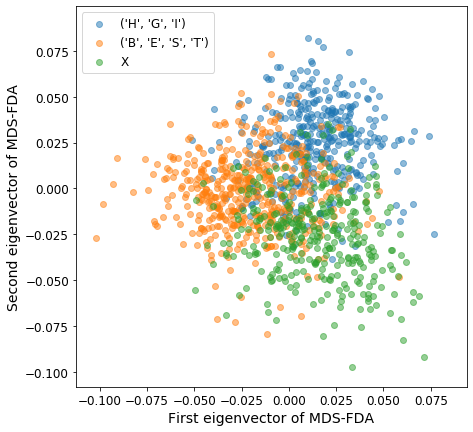

In [20]:
plt.figure(figsize=(7,7))

for c in np.unique(target):
    idx = np.where(target == c)
    plt.scatter(embed[idx, 0], embed[idx, 1], alpha = 0.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('First eigenvector of MDS-FDA', fontsize=14)
plt.ylabel('Second eigenvector of MDS-FDA', fontsize=14)
plt.legend(classes, loc='upper left', fontsize=12)
plt.savefig('example_embedding.png',bbox_inches='tight',dpi=300)
#plt.show()